# <center> Tweets Emotion Detection Using Topic Modelling Features </center>

In [665]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict, Counter
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore','DepricationWarning')

import regex
import re
import string

from PIL import Image

import spacy
import time


import gensim
from spacy.tokenizer import Tokenizer
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# <center> EDA </center>

In [894]:
df = pd.read_csv('data/tweet_emotions.csv')
df

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [4]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

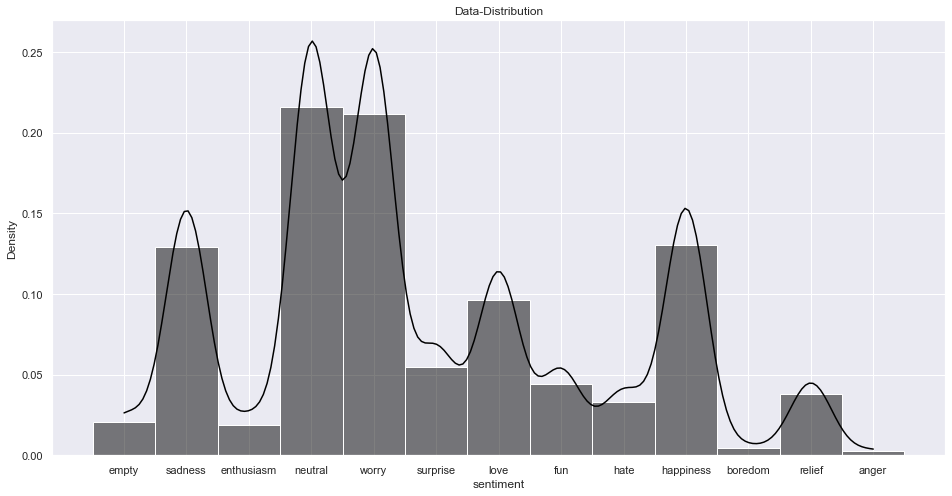

In [13]:
sns.set_style('darkgrid')

plt.figure(figsize=(16,8))
plt.title('Data-Distribution')
sns.histplot(df['sentiment'], kde=True, color='black', stat='density')
plt.show()

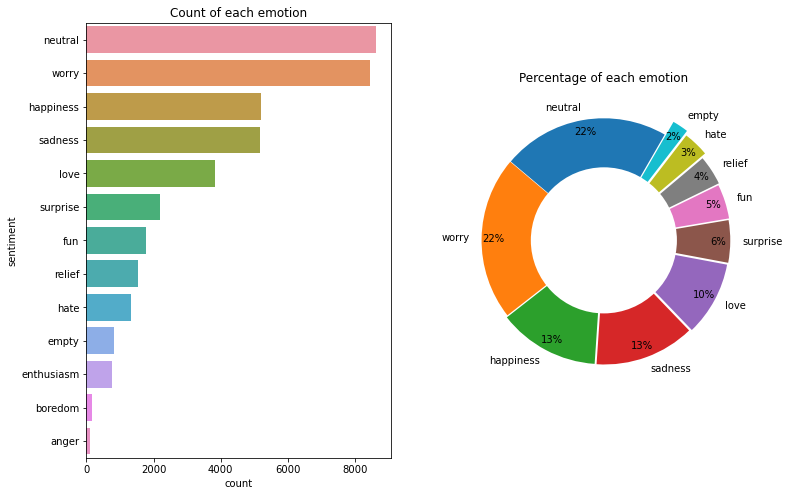

In [827]:
col = 'sentiment'
grouped_df = pd.DataFrame(df[col].value_counts())
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
labels = list(grouped_df.index)
sizes = grouped_df[col]

ax2.pie(sizes[:10],  explode=explode[:10], startangle=60, labels=labels[:10],autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y = col, data = df, ax=ax1, order =labels)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

- ### There are 13 different emotions.
- ### "Neurtal" and "Worry" are the most frequent emotions in the dataset as they compose ~21% of the data each.

### Reduce classes to the top 5 emotions and classify the rest as "other".

In [895]:
df['target'] = df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral', 'love'] else "other") 

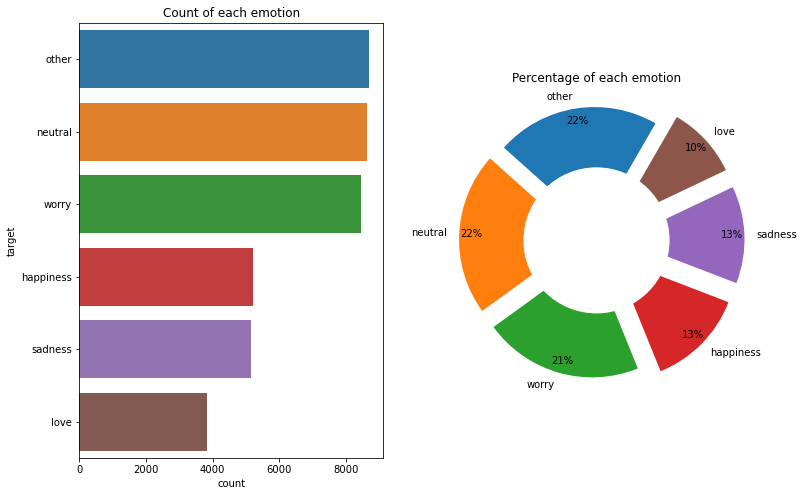

In [829]:
col = 'target'
grouped_df = pd.DataFrame(df[col].value_counts())
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
labels = list(grouped_df.index)
sizes = grouped_df[col]
ax2.pie(sizes[:10],  explode=explode[:10], startangle=60, labels=labels[:10],autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y = col, data = df, ax=ax1, order = labels)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [826]:
grouped_df = pd.DataFrame(df[col].value_counts())
grouped_df

,target
other,8687
neutral,8638
worry,8459
happiness,5209
sadness,5165
love,3842


In [17]:
df['char_length'] = df['content'].apply(lambda x : len(x))
df['token_length'] = df['content'].apply(lambda x : len(x.split(" ")))

### Distribution of character length and token length overall

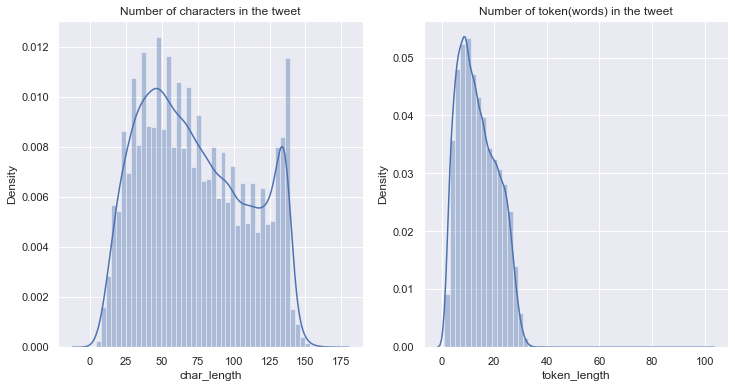

In [18]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df['char_length'], ax=ax1)
sns.distplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

### Distribution of character length sentiment-wise [Top 5 sentiments]

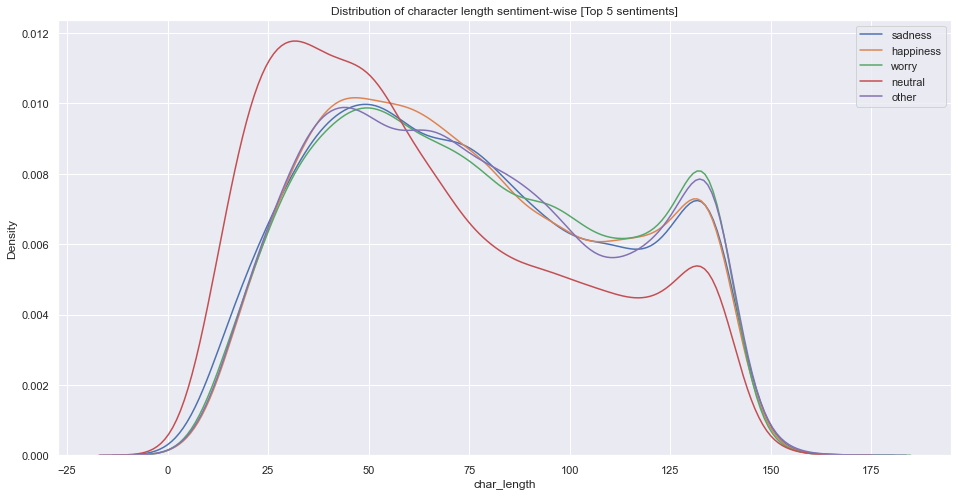

In [19]:
fig, ax = plt.subplots(figsize=(16,8))
for sentiment in df['target'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['target']==sentiment]['char_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 5 sentiments]")
plt.show()

- ### Most of the tweets have around 45 characters.

### Distribution of token length sentiment-wise [Top 5 sentiments]

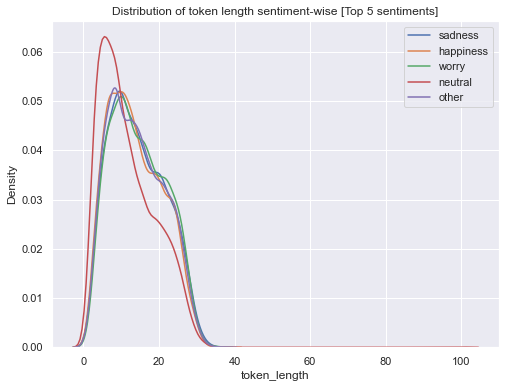

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
for sentiment in df['target'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['target']==sentiment]['token_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of token length sentiment-wise [Top 5 sentiments]")
plt.show()

- ### The most frequent token length is around 10.

### Most common character and token length

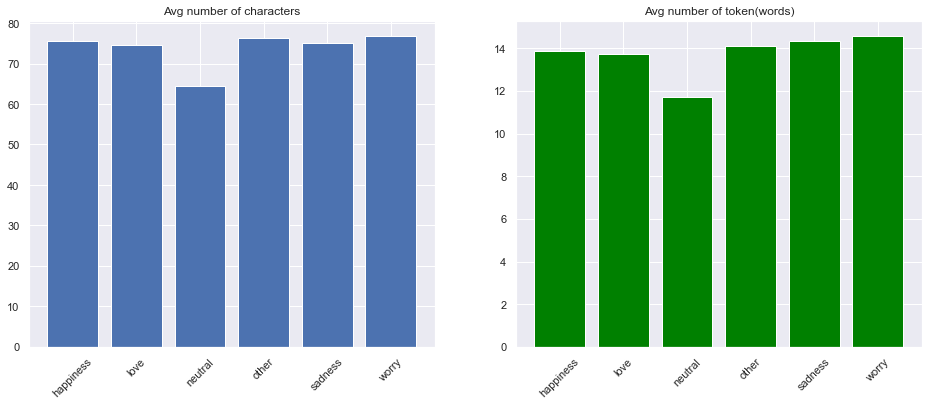

In [21]:
avg_df = df.groupby('target').agg({'char_length':'mean', 'token_length':'mean'})

fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

In [437]:
df['len']=df['content'].apply(lambda x : len([ t for t in x.split()]))

C:\Users\Meshal\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='len', ylabel='target'>

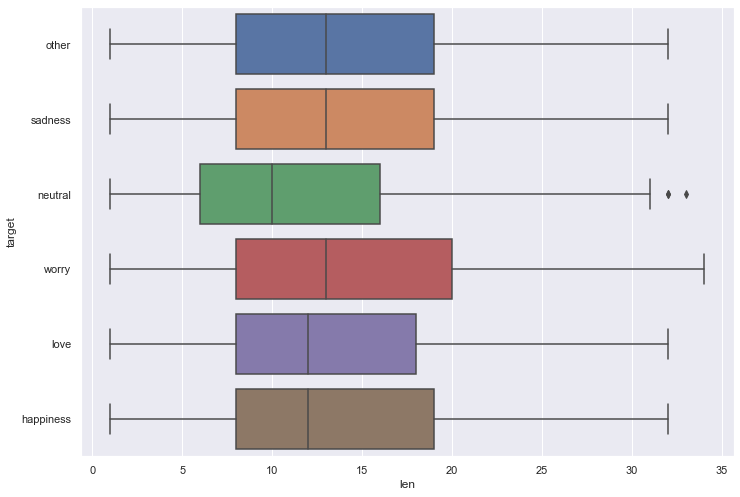

In [830]:
## Relation between sentiment and Tweet length
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(df['len'],y=df['target'])

C:\Users\Meshal\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of length')

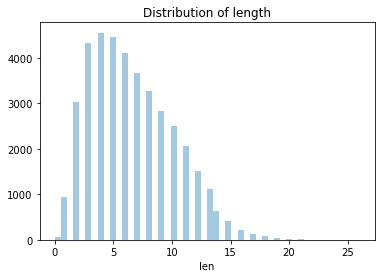

In [428]:
sns.distplot(df['len'],kde=False).set_title('Distribution of length') ## max tweets are about 20 words long

# <center> Text Processing </center>

In [896]:
# remove urls 
df['processed'] = df['content'].replace(r'http\S+', ' ', regex=True)

# convert to lowercase
df['processed']=df['processed'].str.lower()

# contractions
df['processed']=df['processed'].apply(contractions.fix)

## removing account names -- basically after @ words -- those are usernames
df['processed']=df['processed'].apply(lambda x :[t for t in x.split() if not t.startswith('@')] ).apply(lambda x: ' '.join(x))

## removing special characters and number
df['processed'] = df['processed'].replace(r'[^A-Za-z]+', ' ', regex=True)

## removing extra spaces 
df['processed']=df['processed'].apply(lambda x : x.strip())

In [868]:
df

,tweet_id,sentiment,content,target,processed
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,other,i know i was listenin to bad habit earlier and...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,sadness,layin n bed with a headache ughhhh waitin on y...
2,1956967696,sadness,Funeral ceremony...gloomy friday...,sadness,funeral ceremony gloomy friday
3,1956967789,enthusiasm,wants to hang out with friends SOON!,other,wants to hang out with friends soon
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,neutral,we want to trade with someone who has houston ...
...,...,...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor,neutral,
39996,1753919001,love,Happy Mothers Day All my love,love,happy mothers day all my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,love,happy mother s day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness,wassup beautiful follow me peep out my new hit...


## WordClouds

In [857]:
def generate_wordcloud(df,sentiment,colormap='Set2'):

    fig = plt.figure(figsize=[20, 10])
    stopwords = set(STOPWORDS)
    stopwords.update(['quot'])
    temp_df = df1[df1['target']==sentiment]

    corpus = ''
    for text in temp_df.lemmas_back_to_text:
        text = str(text)
        corpus += text

    bird = np.array(Image.open('Twitter-Logo.png'))

    wordcloud = WordCloud(mask=bird,colormap=colormap,min_word_length=4,stopwords=stopwords,
                           collocation_threshold=20,background_color='black').generate(corpus)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis('off')


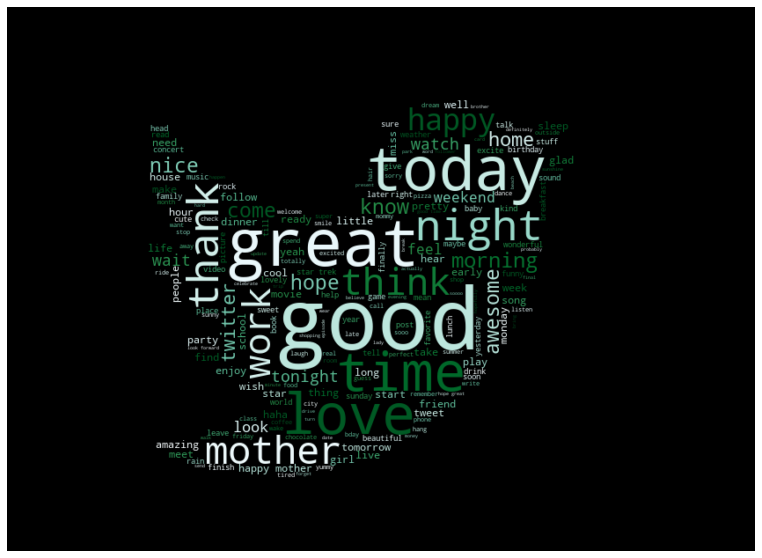

In [858]:
generate_wordcloud(df,'happiness','BuGn')

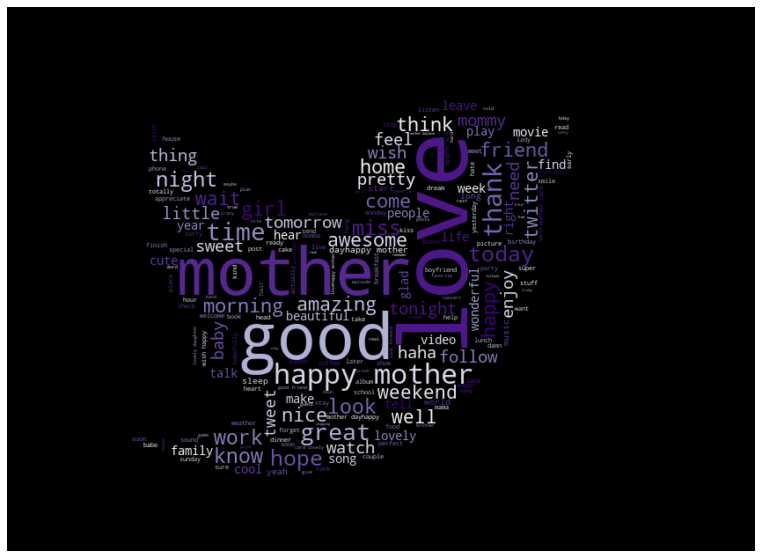

In [859]:
generate_wordcloud(df,'love','Purples')

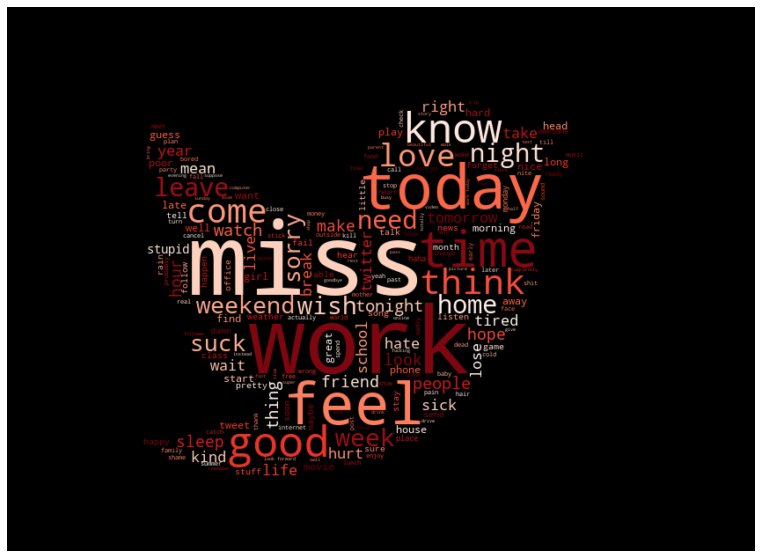

In [861]:
generate_wordcloud(df,'sadness','Reds')

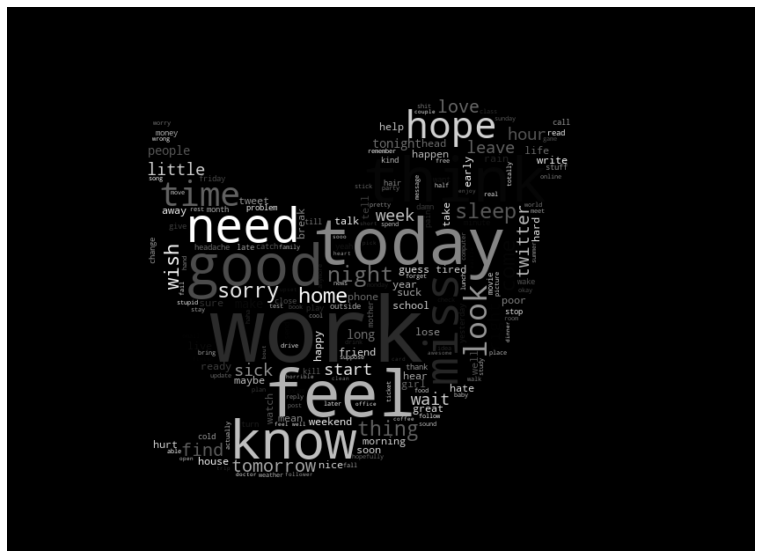

In [863]:
generate_wordcloud(df,'worry','Greys')

In [869]:
nlp = spacy.load('en_core_web_lg')

In [897]:
tokenizer = Tokenizer(nlp.vocab)
custom_stopwords = ['quot','hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords.words("english"))


tokens = []

for doc in tokenizer.pipe(df['processed'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

df['tokens'] = tokens

df

,tweet_id,sentiment,content,target,processed,tokens
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,other,i know i was listenin to bad habit earlier and...,"[know, listenin, bad, habit, earlier, started,..."
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,sadness,layin n bed with a headache ughhhh waitin on y...,"[layin, n, bed, headache, ughhhh, waitin]"
2,1956967696,sadness,Funeral ceremony...gloomy friday...,sadness,funeral ceremony gloomy friday,"[funeral, ceremony, gloomy, friday]"
3,1956967789,enthusiasm,wants to hang out with friends SOON!,other,wants to hang out with friends soon,"[wants, hang, friends, soon]"
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,neutral,we want to trade with someone who has houston ...,"[trade, houston, tickets]"
...,...,...,...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor,neutral,,[]
39996,1753919001,love,Happy Mothers Day All my love,love,happy mothers day all my love,"[happy, mothers, day, love]"
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,love,happy mother s day to all the mommies out ther...,"[happy, mother, s, day, mommies, woman, man, l..."
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness,wassup beautiful follow me peep out my new hit...,"[wassup, beautiful, follow, peep, new, hit, si..."


In [899]:
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def get_lemmas(text):
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)

df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

In [901]:
tokenizer = Tokenizer(nlp.vocab)

def tokenize(text):
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) 
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    tokens = re.sub('\w*\d\w*', '', text)
    tokens = re.sub('@*!*\$*', '', text)
    tokens = tokens.strip(',') 
    tokens = tokens.strip('?') 
    tokens = tokens.strip('!') 
    tokens = tokens.strip("'") 
    tokens = tokens.strip(".") 

    tokens = tokens.lower().split() 
    
    return tokens

df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)

df

<>:22: DeprecationWarning: invalid escape sequence \w
<>:23: DeprecationWarning: invalid escape sequence \$
<>:22: DeprecationWarning: invalid escape sequence \w
<>:23: DeprecationWarning: invalid escape sequence \$
C:\Users\Meshal\AppData\Local\Temp/ipykernel_23888/3527935918.py:22: DeprecationWarning: invalid escape sequence \w
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
C:\Users\Meshal\AppData\Local\Temp/ipykernel_23888/3527935918.py:23: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $


,tweet_id,sentiment,content,target,processed,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,other,i know i was listenin to bad habit earlier and...,"[know, listenin, bad, habit, earlier, started,...",know listenin bad habit earlier started freakin,"[know, listenin, bad, habit, early, start, fre...",know listenin bad habit early start freakin,"[know, listenin, bad, habit, early, start, fre..."
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,sadness,layin n bed with a headache ughhhh waitin on y...,"[layin, n, bed, headache, ughhhh, waitin]",layin n bed headache ughhhh waitin,"[layin, n, bed, headache, ughhhh, waitin]",layin n bed headache ughhhh waitin,"[layin, n, bed, headache, ughhhh, waitin]"
2,1956967696,sadness,Funeral ceremony...gloomy friday...,sadness,funeral ceremony gloomy friday,"[funeral, ceremony, gloomy, friday]",funeral ceremony gloomy friday,"[funeral, ceremony, gloomy, friday]",funeral ceremony gloomy friday,"[funeral, ceremony, gloomy, friday]"
3,1956967789,enthusiasm,wants to hang out with friends SOON!,other,wants to hang out with friends soon,"[wants, hang, friends, soon]",wants hang friends soon,"[wants, hang, friend, soon]",wants hang friend soon,"[wants, hang, friend, soon]"
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,neutral,we want to trade with someone who has houston ...,"[trade, houston, tickets]",trade houston tickets,"[trade, houston, ticket]",trade houston ticket,"[trade, houston, ticket]"
...,...,...,...,...,...,...,...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor,neutral,,[],,[],,[]
39996,1753919001,love,Happy Mothers Day All my love,love,happy mothers day all my love,"[happy, mothers, day, love]",happy mothers day love,"[happy, mother, day, love]",happy mother day love,"[happy, mother, day, love]"
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,love,happy mother s day to all the mommies out ther...,"[happy, mother, s, day, mommies, woman, man, l...",happy mother s day mommies woman man long momm...,"[happy, mother, s, day, mommies, woman, man, l...",happy mother s day mommies woman man long momm...,"[happy, mother, s, day, mommies, woman, man, l..."
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness,wassup beautiful follow me peep out my new hit...,"[wassup, beautiful, follow, peep, new, hit, si...",wassup beautiful follow peep new hit singles w...,"[wassup, beautiful, follow, peep, new, hit, si...",wassup beautiful follow peep new hit single ww...,"[wassup, beautiful, follow, peep, new, hit, si..."


In [906]:
df1 = df.copy()
df1 = df[["content","lemmas_back_to_text","lemma_tokens", "target"]]

In [907]:
df1

,content,lemmas_back_to_text,lemma_tokens,target
0,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit early start freakin,"[know, listenin, bad, habit, early, start, fre...",other
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhh waitin,"[layin, n, bed, headache, ughhhh, waitin]",sadness
2,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,"[funeral, ceremony, gloomy, friday]",sadness
3,wants to hang out with friends SOON!,wants hang friend soon,"[wants, hang, friend, soon]",other
4,@dannycastillo We want to trade with someone w...,trade houston ticket,"[trade, houston, ticket]",neutral
...,...,...,...,...
39995,@JohnLloydTaylor,,[],neutral
39996,Happy Mothers Day All my love,happy mother day love,"[happy, mother, day, love]",love
39997,Happy Mother's Day to all the mommies out ther...,happy mother s day mommies woman man long momm...,"[happy, mother, s, day, mommies, woman, man, l...",love
39998,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,wassup beautiful follow peep new hit single ww...,"[wassup, beautiful, follow, peep, new, hit, si...",happiness


In [908]:
df1 = df1[df1['lemma_tokens'].map(lambda d: len(d)) > 0]

In [909]:
df1

,content,lemmas_back_to_text,lemma_tokens,target
0,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit early start freakin,"[know, listenin, bad, habit, early, start, fre...",other
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhh waitin,"[layin, n, bed, headache, ughhhh, waitin]",sadness
2,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,"[funeral, ceremony, gloomy, friday]",sadness
3,wants to hang out with friends SOON!,wants hang friend soon,"[wants, hang, friend, soon]",other
4,@dannycastillo We want to trade with someone w...,trade houston ticket,"[trade, houston, ticket]",neutral
...,...,...,...,...
39994,Succesfully following Tayla!!,succesfully follow tayla,"[succesfully, follow, tayla]",happiness
39996,Happy Mothers Day All my love,happy mother day love,"[happy, mother, day, love]",love
39997,Happy Mother's Day to all the mommies out ther...,happy mother s day mommies woman man long momm...,"[happy, mother, s, day, mommies, woman, man, l...",love
39998,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,wassup beautiful follow peep new hit single ww...,"[wassup, beautiful, follow, peep, new, hit, si...",happiness


# Topic Modelling

### LDA - CountVectorizer

In [910]:
from sklearn.decomposition import LatentDirichletAllocation
vec = CountVectorizer(
analyzer='word',       
min_df=3,
stop_words='english',
lowercase=True,
token_pattern='[a-zA-Z0-9]{3,}',
max_features=5000
                            )
vec_dm = vec.fit_transform(df1['lemmas_back_to_text'])
vec_dm

<39584x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 186076 stored elements in Compressed Sparse Row format>

In [911]:
lda_model = LatentDirichletAllocation(
n_components=6, 
learning_method='online',
random_state=20,       
                                     )
lda_vec_output = lda_model.fit_transform(vec_dm)

In [912]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, vec_dm, vec)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.014134  0.155041       1        1  20.018560
5      0.301681  0.067815       2        1  18.048023
0     -0.235898  0.216774       3        1  16.520591
3     -0.161274 -0.332012       4        1  15.616388
2      0.190058 -0.123031       5        1  15.215651
4     -0.108701  0.015413       6        1  14.580788, topic_info=        Term         Freq        Total Category  logprob  loglift
1867    good  2773.000000  2773.000000  Default  30.0000  30.0000
1134     day  4021.000000  4021.000000  Default  29.0000  29.0000
1988   happy  1910.000000  1910.000000  Default  28.0000  28.0000
4398   thank  1639.000000  1639.000000  Default  27.0000  27.0000
2889  mother  1637.000000  1637.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
745    check   182.381566   287.609044   Topic6  -5.0303   1.4700
4416   think   259.531725  1433.747456   Topic6  -4.6775   0.2163
4478   today   251.018206  1529.709487   Topic6  -4.7109   0.1182
4457    time   245.453585  1504.979323   Topic6  -4.7333   0.1120
2456    late   162.229743   246.357130   Topic6  -5.1474   1.5077

[275 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
82        6  0.991232        ago
143       1  0.995973    amazing
153       4  0.999049        amp
233       2  0.992844        ask
280       3  0.996774       away
...     ...       ...        ...
4944      1  0.998682        yay
4950      3  0.998540       yeah
4953      6  0.998430       year
4960      5  0.997889        yes
4965      3  0.996922  yesterday

[279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 4, 3, 5])

### LDA - TF-IDF

In [913]:
tfidf.fit_transform(df1['lemmas_back_to_text'])

tfidf = TfidfVectorizer(
analyzer='word',       
min_df=3,
stop_words='english,
lowercase=True,
token_pattern='[a-zA-Z0-9]{3,}',
max_features=5000,
                            )
tfidf_dm = tfidf.fit_transform(df1['lemmas_back_to_text'])
tfidf_dm

<39584x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 186076 stored elements in Compressed Sparse Row format>

In [914]:
lda_model = LatentDirichletAllocation(
n_components=6, 
learning_method='online',
random_state=20,       
n_jobs = -1  
                                     )
lda_tfidf_output = lda_model.fit_transform(tfidf_dm)

In [915]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, tfidf_dm, tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.054569  0.080756       1        1  19.576297
5      0.049225 -0.013435       2        1  17.234675
3      0.163140  0.039777       3        1  16.614417
4      0.084884 -0.311623       4        1  16.045797
1      0.020707  0.234997       5        1  15.647544
0     -0.372526 -0.030471       6        1  14.881269, topic_info=         Term         Freq        Total Category  logprob  loglift
4398    thank   674.000000   674.000000  Default  30.0000  30.0000
2889   mother   603.000000   603.000000  Default  29.0000  29.0000
2097     home   325.000000   325.000000  Default  28.0000  28.0000
1134      day  1015.000000  1015.000000  Default  27.0000  27.0000
2882  morning   363.000000   363.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2555     live    92.001879   136.417949   Topic6  -4.8571   1.5112
1711   forget    66.469605    86.902468   Topic6  -5.1821   1.6370
1867     good    94.568476   791.431209   Topic6  -4.8296  -0.2195
1988    happy    68.218725   627.117116   Topic6  -5.1562  -0.3133
2882  morning    66.910308   363.381554   Topic6  -5.1755   0.2130

[304 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
143       1  0.990081    amazing
153       1  0.247728        amp
153       3  0.516100        amp
153       4  0.233965        amp
189       4  0.990465    anymore
...     ...       ...        ...
4953      3  0.751262       year
4958      3  0.975868        yep
4960      2  0.998102        yes
4965      6  0.994289  yesterday
4976      2  0.992095    youtube

[356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 4, 5, 2, 1])

### LSA - CountVectorizer

In [953]:
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(vec_dm, vec.fit_transform(df1['lemmas_back_to_text']))

print('Variance Ratio:')
print(lsa.explained_variance_ratio_,'\n')

print('Sum of Variance Ratio:',lsa.explained_variance_ratio_.sum(),'\n')

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic", ix)
        else:
            print("\nTopic:",topic_names[ix])
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print('Topics:')
model = lsa
feature_names = vec.get_feature_names()
no_top_words = 10
topic_names = None
for ix, topic in enumerate(model.components_):
    if not topic_names or not topic_names[ix]:
        print("\nTopic", ix)
    else:
        print("\nTopic:",topic_names[ix])
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

column_names = []
for i in range(0,19):
    column_names.append('Topic_' + str(i))


Variance Ratio:
[0.02415037 0.01314994 0.01195438 0.0111667  0.00908953 0.00836921] 

Sum of Variance Ratio: 0.07788012392708184 

Topics:

Topic 0
day, mother, happy, good, work, love, today, mom, amp, time

Topic 1
day, mother, happy, mom, frenchieb, mommy, war, mum, card, receive

Topic 2
work, love, today, time, amp, lol, know, think, miss, home

Topic 3
love, know, lol, amp, happy, thank, think, miss, mother, new

Topic 4
love, work, good, mother, happy, morning, mom, luck, mommy, world

Topic 5
today, day, love, feel, time, miss, come, frenchieb, home, school


### LSA - TF-IDF

In [954]:
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(tfidf_dm, tfidf.fit_transform(df1['lemmas_back_to_text']))

print('Variance Ratio:')
print(lsa.explained_variance_ratio_,'\n')

print('Sum of Variance Ratio:',lsa.explained_variance_ratio_.sum(),'\n')

print('Topics:')
model = lsa
feature_names = vec.get_feature_names()
no_top_words = 10
topic_names = None
for ix, topic in enumerate(model.components_):
    if not topic_names or not topic_names[ix]:
        print("\nTopic", ix)
    else:
        print("\nTopic:",topic_names[ix])
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

column_names = []
for i in range(0,19):
    column_names.append('Topic_' + str(i))


Variance Ratio:
[0.01170992 0.00704136 0.00837836 0.00767106 0.00598357 0.00589777] 

Sum of Variance Ratio: 0.04668204083872717 

Topics:

Topic 0
day, mother, happy, good, mom, work, love, today, thank, morning

Topic 1
thank, good, work, morning, love, know, time, today, miss, night

Topic 2
thank, mother, follow, happy, mom, appreciate, love, followfriday, god, follower

Topic 3
work, thank, mother, tomorrow, happy, hour, ready, wish, friday, today

Topic 4
miss, love, know, lol, time, think, sad, home, come, feel

Topic 5
miss, thank, day, sad, good, morning, today, home, friend, school


# Topic Models As Feature Vectors to Supervised Classifiers

In [919]:
le = LabelEncoder()
data = df1.copy()
data['target_encoded']= le.fit_transform(data['target'])

In [935]:
X = np.array(lda_vec_output)

y = np.array(data['target_encoded'])

In [952]:
train = pd. DataFrame(X, columns=['Topic1', 'Topic2', 'Topic3','Topic3','Topic4','Topic5'])
train['target'] = data['target']
train['target_encoded'] = y
train.head()

,Topic1,Topic2,Topic3,Topic3,Topic4,Topic5,target,target_encoded
0,0.020848,0.449249,0.467249,0.020957,0.020864,0.020833,other,3
1,0.033333,0.233211,0.033467,0.633322,0.033333,0.033333,sadness,4
2,0.833333,0.033333,0.033333,0.033333,0.033333,0.033333,sadness,4
3,0.033333,0.233090,0.033578,0.633332,0.033333,0.033333,other,3
4,0.041667,0.041667,0.791666,0.041667,0.041667,0.041667,neutral,2


In [937]:
X.shape

(39584, 6)

In [938]:
y.shape

(39584,)

In [939]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

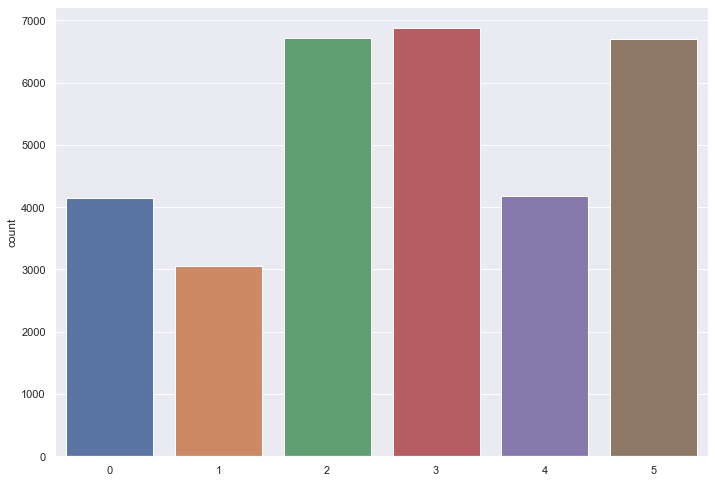

In [940]:
sns.countplot(x = y_train);

In [941]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler 

The total observations before: 31667
The total observations after: 41256


<AxesSubplot:ylabel='count'>

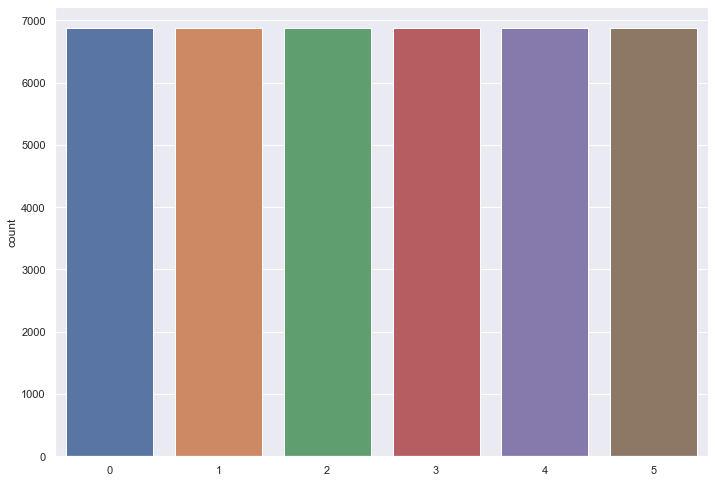

In [942]:
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("The total observations before:", len(y_train))
print("The total observations after:", len(y_train_res))

sns.countplot(x = y_train_res)

## Classifiers

In [943]:
def get_results(modelname):
    model = modelname.fit(X_train_res,y_train_res)
    pred=model.predict(X_test)
    print()
    print(classification_report(y_test, pred))
    cnf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()

### XGB

C:\Users\Meshal\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

              precision    recall  f1-score   support

           0       0.16      0.17      0.16      1051
           1       0.27      0.31      0.29       769
           2       0.31      0.36      0.33      1696
           3       0.24      0.20      0.22      1730
           4       0.15      0.16      0.15       968
           5       0.23      0.19      0.21      1703

    accuracy                           0.24      7917
   macro avg       0.23      0.23      0.23      7917
weighted avg       0.23      0.24      0.23      7917



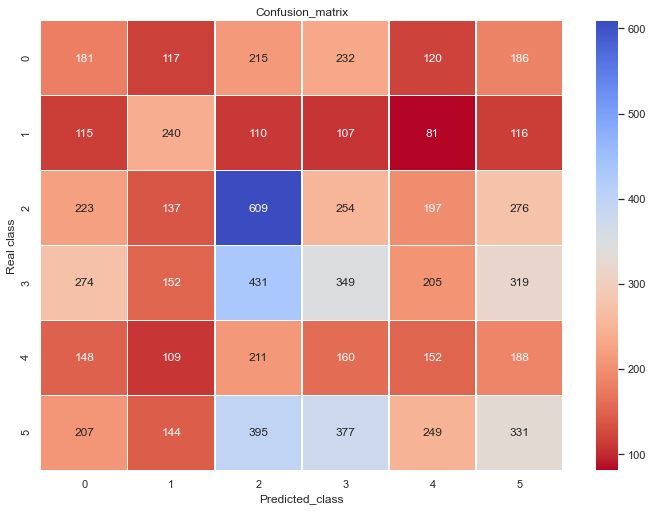

In [944]:
get_results(XGBClassifier());

### Gaussain Naive Bayes


              precision    recall  f1-score   support

           0       0.15      0.39      0.22      1051
           1       0.14      0.46      0.21       769
           2       0.22      0.13      0.17      1696
           3       0.26      0.08      0.12      1730
           4       0.15      0.09      0.11       968
           5       0.24      0.08      0.12      1703

    accuracy                           0.17      7917
   macro avg       0.19      0.21      0.16      7917
weighted avg       0.21      0.17      0.15      7917



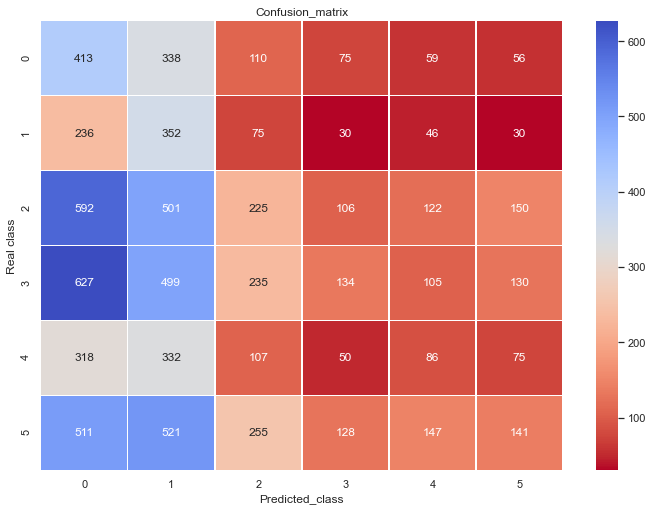

In [945]:
get_results(GaussianNB())


              precision    recall  f1-score   support

           0       0.14      0.23      0.17       999
           1       0.14      0.32      0.19       773
           2       0.30      0.30      0.30      1678
           3       0.23      0.04      0.06      1768
           4       0.15      0.17      0.16      1006
           5       0.25      0.21      0.23      1693

    accuracy                           0.20      7917
   macro avg       0.20      0.21      0.18      7917
weighted avg       0.22      0.20      0.19      7917



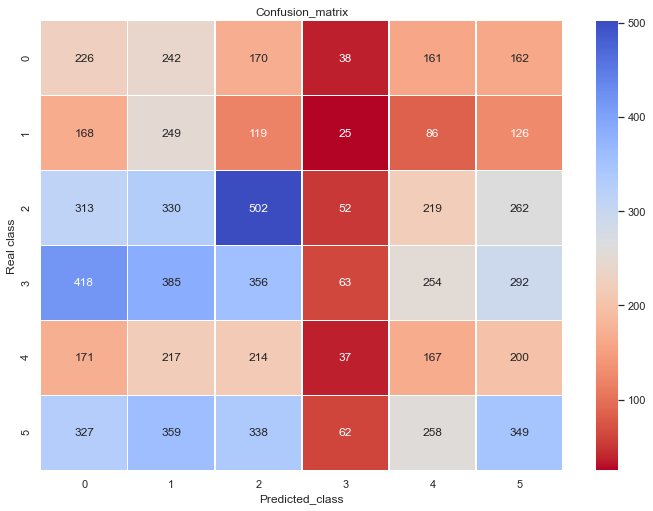

In [931]:
get_results(svm.SVC())

### RANDOM FOREST


              precision    recall  f1-score   support

           0       0.14      0.14      0.14      1051
           1       0.22      0.25      0.23       769
           2       0.29      0.33      0.31      1696
           3       0.22      0.20      0.21      1730
           4       0.15      0.15      0.15       968
           5       0.22      0.19      0.20      1703

    accuracy                           0.22      7917
   macro avg       0.21      0.21      0.21      7917
weighted avg       0.22      0.22      0.22      7917



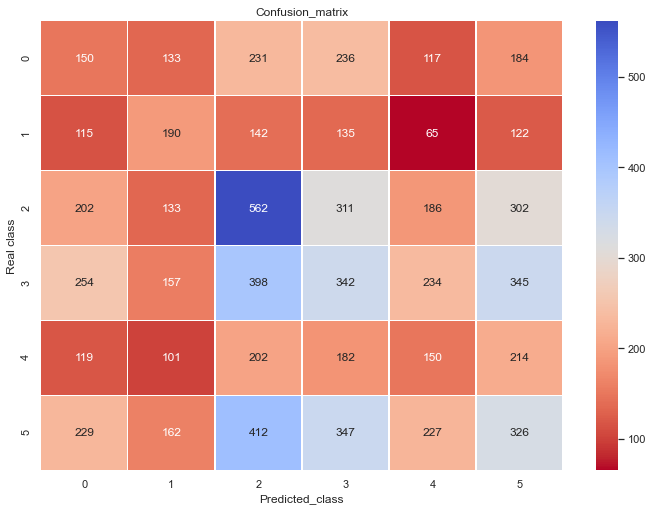

In [946]:
get_results(RandomForestClassifier())

### Multinomial Naive Bayes

In [933]:
from sklearn.naive_bayes import MultinomialNB


              precision    recall  f1-score   support

           0       0.16      0.29      0.20      1051
           1       0.14      0.44      0.21       769
           2       0.23      0.18      0.20      1696
           3       0.28      0.08      0.13      1730
           4       0.14      0.18      0.16       968
           5       0.24      0.07      0.11      1703

    accuracy                           0.17      7917
   macro avg       0.20      0.21      0.17      7917
weighted avg       0.21      0.17      0.16      7917



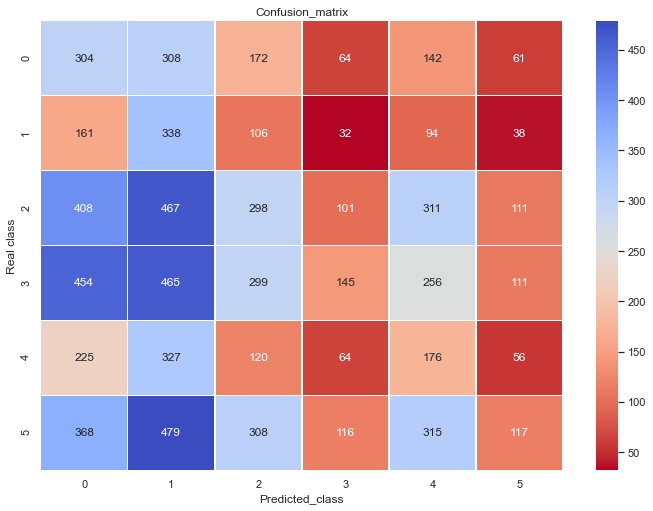

In [947]:
get_results(MultinomialNB())